In [1]:
import numpy as np
import sys
import dimod
import matplotlib.pyplot as plt
import os
import re
import neal

from dwave.system import EmbeddingComposite, DWaveSampler, ReverseAdvanceComposite
from dwave_qbsolv import QBSolv
from pyqubo import Spin, Array
from embedding_generator import generate_embedding

In [2]:
# Define variables here

num_events = 1000
path = '/Users/1zd/quantumjets/pythiaEvents/'

theta = np.pi/2.

In [5]:
qubo_max = list()
npart = list()

for ev in range(0, num_events):
    #print(ev)

    fname = path + 'Event_' + str(ev) + '.dat'
    f = open(fname)

    pat = re.compile(r"\s+")

    g = list(zip(*[ pat.sub(" ",x.strip()).split() for x in f]))

    px = np.array([ float(x) for x in g[0]])
    py = np.array([ float(x) for x in g[1]])
    pz = np.array([ float(x) for x in g[2]])
    e = np.array([ float(x) for x in g[3]])

    # Generate qubo

    n_part = len(px)
    npart.append(n_part)
    #print(n_part)
    s = Array.create('s', shape=n_part, vartype='BINARY')

    # Create an array of zeroes for qubo matrix coefficients
    coeff = [[0] * n_part for _ in range(n_part)] 

    for i in range(0,n_part):
        for j in range(0,n_part):
            coeff[i][j] = (px[i]*px[j] +py[i]*py[j] + pz[i]*pz[j] - e[i]*e[j] * np.cos(theta))/(1 - np.cos(theta))

    # Construct Hamiltonian
    H = sum([ -1.0*coeff[i][j]*s[i]*s[j] for i in range(0,n_part) for j in range(0,n_part)])

    # Compile model using pyqubo

    model = H.compile()
    qubo, offset = model.to_qubo()

    ch_str = qubo[max(qubo, key=qubo.get)]
    qubo_max.append(ch_str)


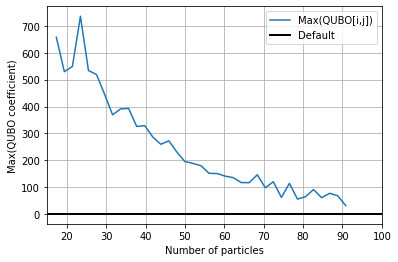

In [19]:
from scipy.stats import binned_statistic

s, edges, _ = binned_statistic(npart, qubo_max, statistic='mean', bins=np.linspace(0,100, 50))

ys = np.repeat(s,2)
xs = np.repeat(edges,2)[1:-1]

ax1 = plt.subplot(111)
ax1.plot(edges[:-1]+np.diff(edges)/2, s, zorder=3, label='Max(QUBO[i,j])')


ax1.set_xlabel('Number of particles')
ax1.set_ylabel('Max(QUBO coefficient)')
#ax1.legend(loc='right')

ax1.grid()
ax1.set_xlim([15,100])

ax1.plot([15,100], [1,1], 'k-', lw=2, label='Default')
#ax1.set_ylim([-2,70])

#plt.setp(ax1.get_xticklabels(), visible=False)
#plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.legend(loc='upper right')

#plt.grid()
#plt.ylim([-2,130])
#plt.xlim([15,90])
#plt.yscale('log')
plt.savefig('plots/chain_strength_vs_npart.png', bbox_inches="tight")
plt.show()